In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [3]:
# Load the iris dataset
df = datasets.load_iris()
df = pd.DataFrame(df.data, columns = df.feature_names)
df.head() 
# See the first 5 rows

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
# To know number of rows and collumns
df.shape

(150, 4)

In [5]:
# To find if any null value is present
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

In [6]:
# To see summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


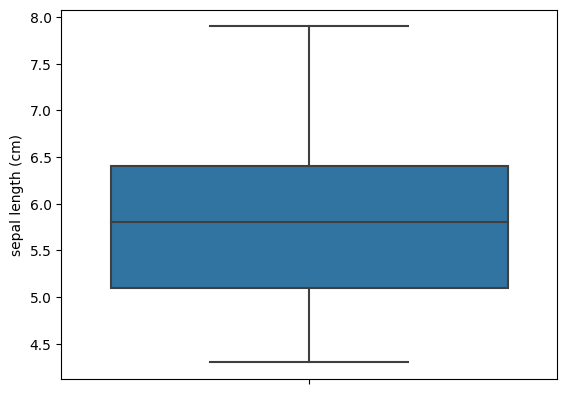

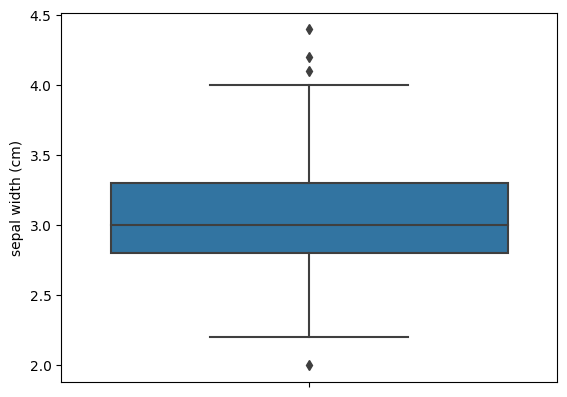

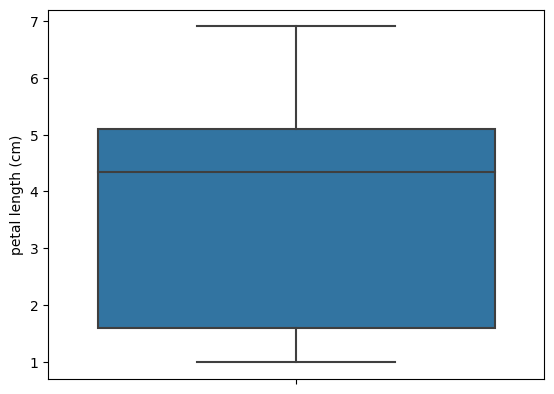

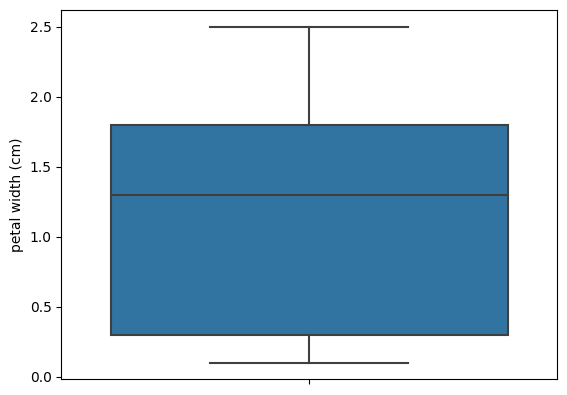

In [7]:
# To find outliers
cols = df.columns
for i in cols:
    sns.boxplot(y=df[i])
    plt.show()

In [8]:
# To remove outliers from 'sepal width (cm)'
q1 = df['sepal width (cm)'].quantile(0.25)
q3 = df['sepal width (cm)'].quantile(0.75)
iqr = q3 - q1
df = df[(df['sepal width (cm)'] >= q1-1.5*iqr) & (df['sepal width (cm)'] <= q3+1.5*iqr)]
df.shape # To find out the number of rows and column after outlier treatment

(146, 4)

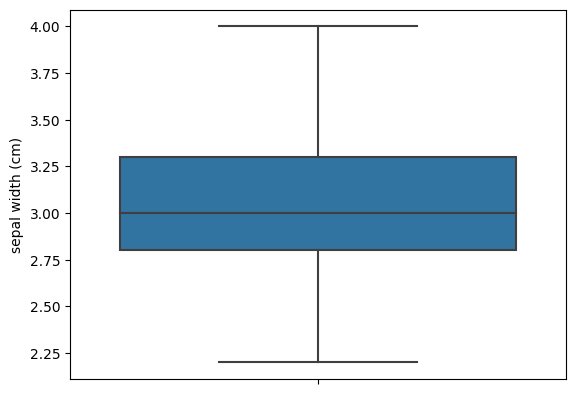

In [9]:
#We can see that after outlier treatment the number of roes are reduced to 146 from 150
# Blocplot for sepal width (cm) after outlier treatment
sns.boxplot(y=df['sepal width (cm)'])
plt.show()

In [10]:
# Standardizing to avoid bias
standard_scaler = StandardScaler()
df_norm = standard_scaler.fit_transform(df)

In [11]:
#To find the optimal no. of cluster
cluster_range = range(1,20)
cluster_errors = []

for num_cluster in cluster_range:
    clusters = KMeans(num_cluster, n_init = 10)
    clusters.fit(df_norm)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
    
clusters_df = pd.DataFrame({'num_cluster': cluster_range, 'cluster_errors': cluster_errors})
clusters_df[0:20]

,num_cluster,cluster_errors
0,1,584.000000
1,2,217.499302
2,3,134.345832
3,4,109.767399
4,5,88.938329
5,6,77.731235
6,7,68.846696
7,8,61.062641
8,9,52.686375
9,10,46.450352


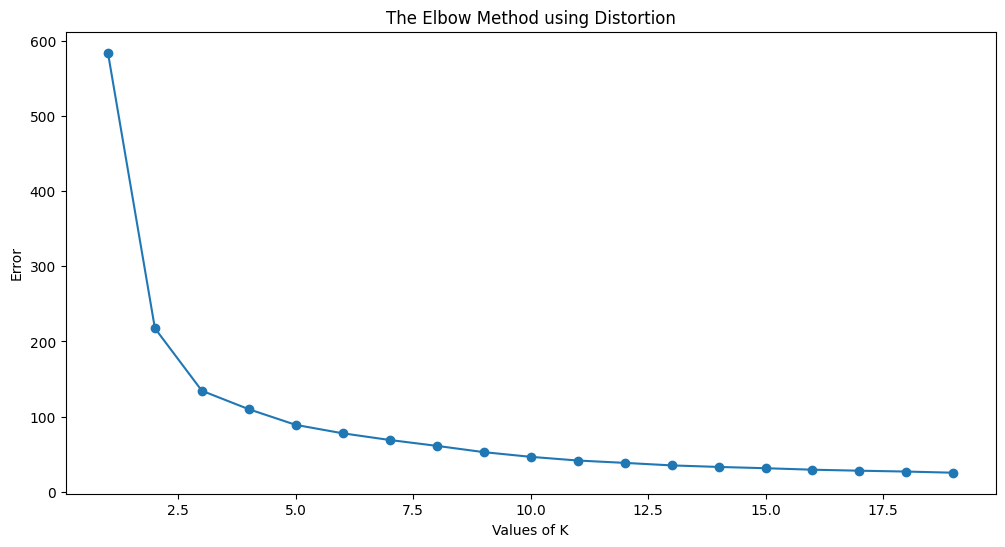

In [12]:
#Ploting elbow curve or sree to find the no. of cluster
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_cluster, clusters_df.cluster_errors, marker = 'o') 
plt.xlabel('Values of K') 
plt.ylabel('Error') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [13]:
#From the above elbow curve we can say that '3' is the optimal number of cluster
# Creating object of the model and fitting it
model = KMeans(n_clusters=3, max_iter=50)
model.fit(df)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [14]:
#analysis of cluster found
df.index = pd.RangeIndex(len(df.index))
df_km = pd.concat([df, pd.Series(model.labels_)], axis=1)
df_km.columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'ClusterID']

km_clusters_Slength = pd.DataFrame(df_km.groupby(['ClusterID']).agg({'sepal length (cm)':'mean'}))
km_clusters_Swidth = pd.DataFrame(df_km.groupby(['ClusterID']).agg({'sepal width (cm)':'mean'}))
km_clusters_Plength = pd.DataFrame(df_km.groupby(['ClusterID']).agg({'petal length (cm)':'mean'}))
km_clusters_Pwidth = pd.DataFrame(df_km.groupby(['ClusterID']).agg({'petal width (cm)':'mean'}))

df2 = pd.concat([pd.Series([0,1,2]), km_clusters_Slength, km_clusters_Swidth, km_clusters_Plength, km_clusters_Pwidth
                ], axis=1)
df2.columns = ['ClusterID','sepal length (cm)_mean','sepal width (cm)_mean','petal length (cm)_mean',
               'petal width (cm)_mean']
df2.head()

,ClusterID,sepal length (cm)_mean,sepal width (cm)_mean,petal length (cm)_mean,petal width (cm)_mean
0,0,6.850000,3.073684,5.742105,2.071053
1,1,4.976596,3.376596,1.461702,0.246809
2,2,5.916393,2.760656,4.408197,1.440984


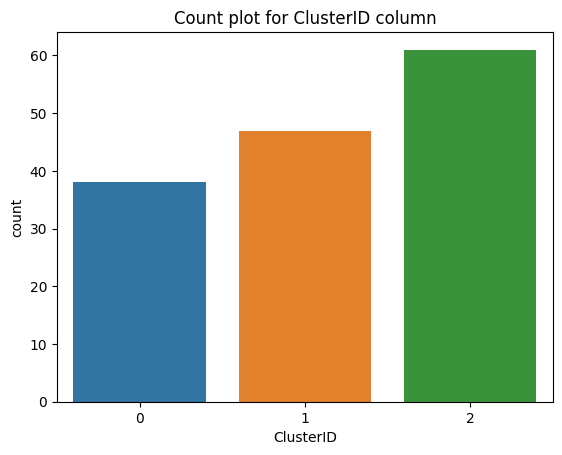

In [15]:
sns.countplot(x=df_km.ClusterID)
plt.title('Count plot for ClusterID column')
plt.show()

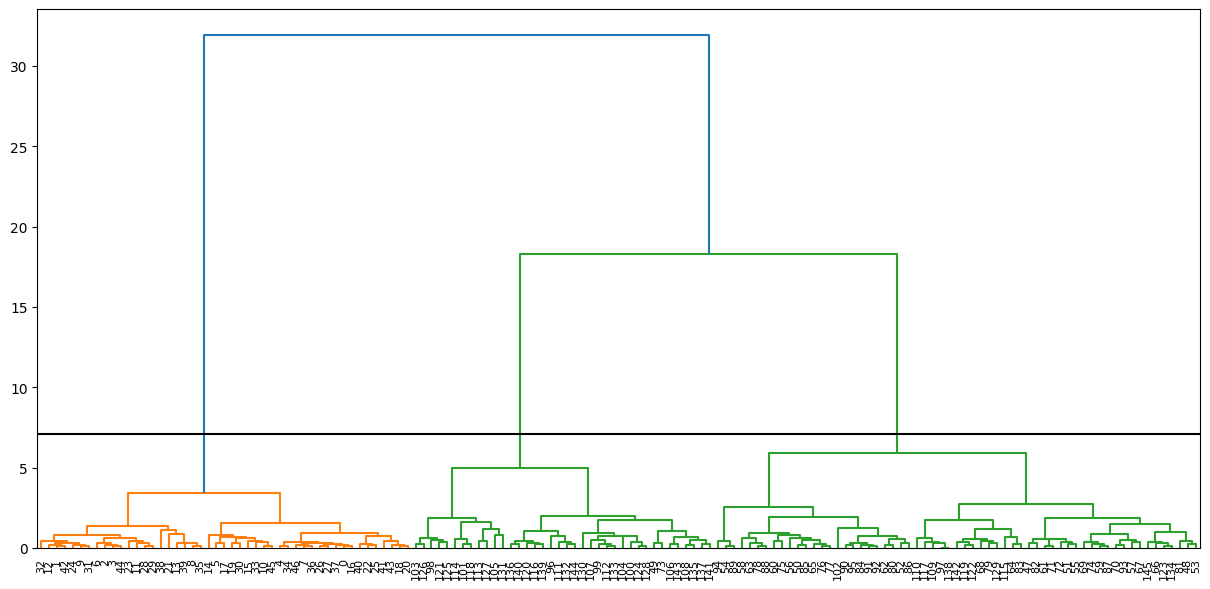

In [16]:
#heirarchical clustering with full dendrogram
plt.figure(figsize=(15,7))
mergings = linkage(df_km, method = 'ward', metric='euclidean')

# set cut-off to 50
max_d = 7.08                # max_d as in max_distance
dendrogram(mergings,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=150,                  # Try changing values of p
           leaf_rotation=90.,      # rotates the x axis labels
           leaf_font_size=8.,      # font size for the x axis labels
          )

plt.axhline(y=max_d, c='k')
plt.show()

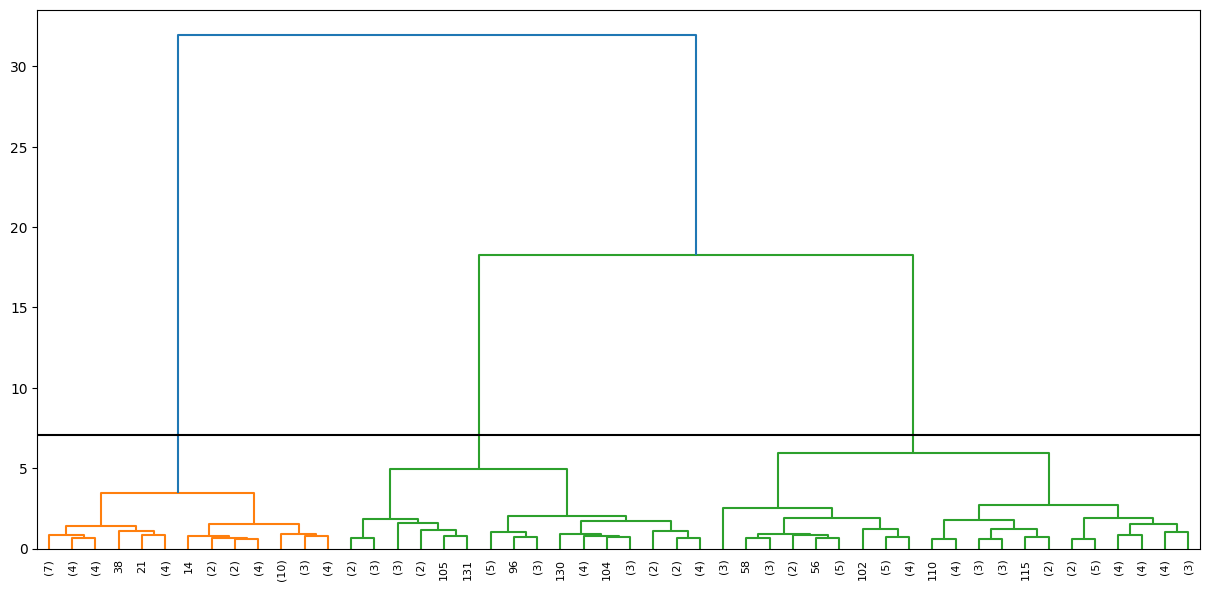

In [17]:
#heirarchical clustering with full dendrogram for 50
plt.figure(figsize=(15,7))
mergings = linkage(df_km, method = 'ward', metric='euclidean')

# set cut-off to 50
max_d = 7.08                # max_d as in max_distance
dendrogram(mergings,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=50,                  # Try changing values of p
           leaf_rotation=90.,      # rotates the x axis labels
           leaf_font_size=8.,      # font size for the x axis labels
          )

plt.axhline(y=max_d, c='k')
plt.show()

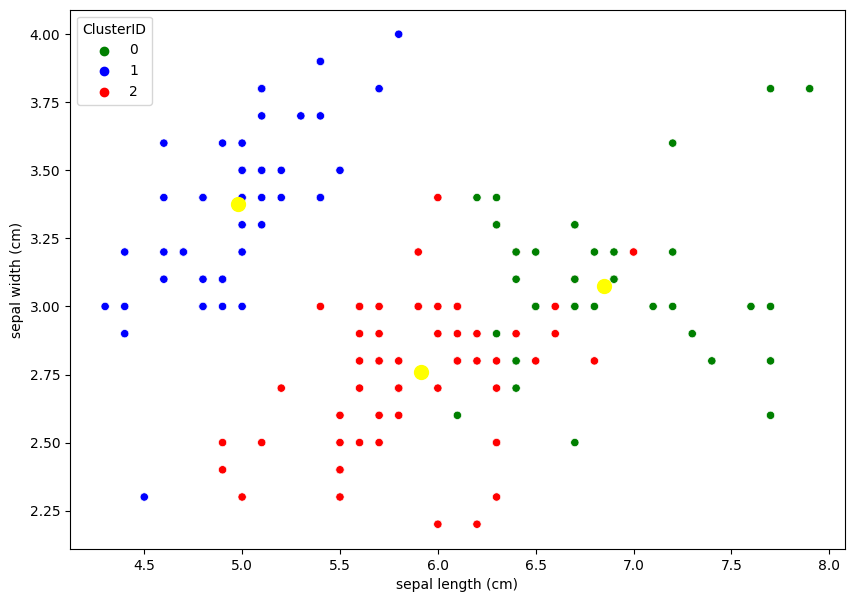

In [18]:
#From the above two dendrogram we can say that there are three cluster
# Scatter plot to visualize the clusters
plt.figure(figsize=(10,7))
sns.scatterplot(x='sepal length (cm)',y='sepal width (cm)', data=df_km, hue='ClusterID', palette=['green','blue','red'])

# Plotting the centroids of the clusters
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:,1], 
            s = 100, c = 'yellow', label = 'Centroids')
plt.show()